## Time Series Analysis: Atmospheric CO2 Concentration

#### Globally Averaged Marine surface monthly mean data of C02

#### From

#### Lan, X., Tans, P. and K.W. Thoning: Trends in globally-averaged CO2 determined from NOAA Global Monitoring Laboratory measurements. Version 2024-01



In [7]:
#!pip install Numpy==1.23.5 --user
# ' module 'numpy' has no attribute 'MachAr''

In [2]:
# Required Packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# Incase of deprecated alias
#np.float = float    
#np.int = int   #module 'numpy' has no attribute 'int'
#np.object = object    #module 'numpy' has no attribute 'object'
#np.bool = bool    #module 'numpy' has no attribute 'bool'
#np.long = np.longlong

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import scipy.stats as scs
import warnings

In [3]:
# Import Excel file

df=pd.read_csv(r"C:\Users\New User\Desktop\co2_mm_gl2.csv")



In [4]:
#### View data set
print(df.head())


   year  month   decimal  average  average_unc   trend  trend_unc       log
0  1979      1  1979.042   336.56         0.10  335.92       0.09  5.818776
1  1979      2  1979.125   337.29         0.09  336.25       0.09  5.820943
2  1979      3  1979.208   337.88         0.10  336.51       0.09  5.822691
3  1979      4  1979.292   338.32         0.11  336.72       0.09  5.823992
4  1979      5  1979.375   338.26         0.04  336.71       0.10  5.823815


In [18]:
# Data set does not have appropriate date column.
# Will need to make one and add it to dataframe and set it as index!
df['date']=pd.date_range(start='1/1979', periods=len(df), freq='M')
df['date'] = pd.to_datetime(df.date) 

df.set_index(['date'],drop=True) # set drop = True to avoid duplicate date column
print(df.head())


   year  month   decimal  average  average_unc   trend  trend_unc       log  \
0  1979      1  1979.042   336.56         0.10  335.92       0.09  5.818776   
1  1979      2  1979.125   337.29         0.09  336.25       0.09  5.820943   
2  1979      3  1979.208   337.88         0.10  336.51       0.09  5.822691   
3  1979      4  1979.292   338.32         0.11  336.72       0.09  5.823992   
4  1979      5  1979.375   338.26         0.04  336.71       0.10  5.823815   

        date  
0 1979-01-31  
1 1979-02-28  
2 1979-03-31  
3 1979-04-30  
4 1979-05-31  


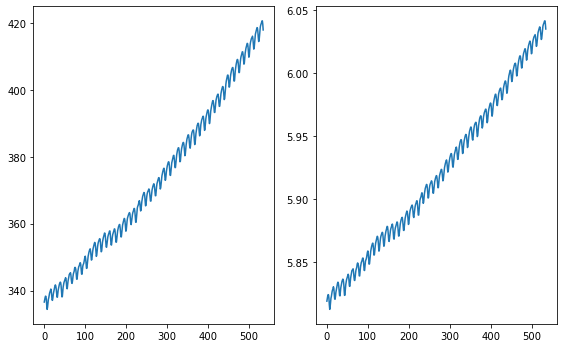

In [6]:
#### Visualise Time Series
pd.to_datetime(df.date)
#df['average'].plot()
#plt.show()

#df['log'].plot()
#plt.show()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
fig.tight_layout()
ax1.plot(df.average)
ax2.plot(df.log)
plt.show()


Imported data is clearly non stationary. There is an obvious linear and seasonal trend present. We could do an Augmented Dickey Fuller Test confirm this at the 5% significance level, but this is unnecessary.

The Log transform of the data already done for us in the excel file shows minimal change, mostly just straightening out the linear trend. 


### ACF and PACF Plots

In [7]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


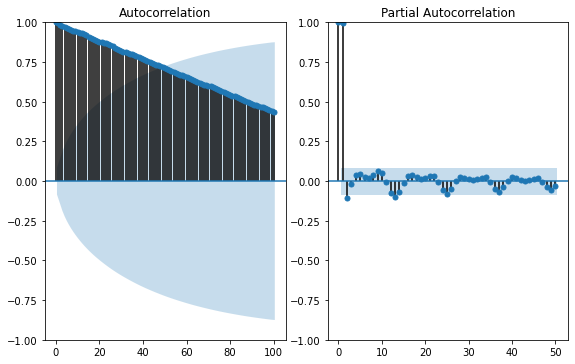

In [8]:

#plot_acf(df.average,lags=100)
#plt.show()

#plot_pacf(df.average,lags=50)
#plt.show()


fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.tight_layout()
sm.graphics.tsa.plot_acf(df.average,lags=100, ax=ax[0])
sm.graphics.tsa.plot_pacf(df.average,lags=50, ax=ax[1])
plt.show()

The ACF plot shows that the acf is not cutting off, but slowlying decaying as go further out in the lags.

The PACF has a clear spike at the first lag then cuts off. However, we notice that at about every 12th lag = 12 months there a noticeable spike in pacf. This could be indicating the natural frequency of the repeating oscillations evident in the data

### 1st Order Differencing: Removing Linear Trend

To remove the linear trend, we can easily apply a first order difference so we are only left with the seasonal trend of the data

The Pandas Package comes with a built in differencing function for 1st order
For higher orders, more applicable to use statsmodels


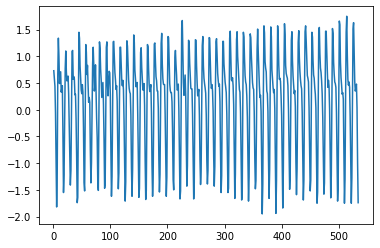

In [9]:
### Manually create a function to do the differencing

#def dif1(df, interval=1):
 #   diff =list()
  #  for i in range(interval, len(df)):
   #     val = df[i]-df[i-interval]
    #    diff.append(val)
        
   # return pd.Series(diff)

#diff=dif1(df.average)
#plt.plot(diff)

dif1 = sm.tsa.statespace.tools.diff(df.average) # default dif is 1

plt.plot(dif1)
plt.show()

Very easily we have removed the linear and are now only left with the seasonal component.


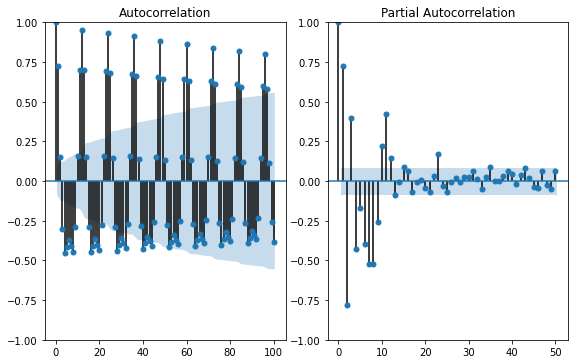

In [10]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.tight_layout()
sm.graphics.tsa.plot_acf(dif1,lags=100, ax=ax[0])
sm.graphics.tsa.plot_pacf(dif1,lags=50, ax=ax[1])
plt.show()

Our ACF and PACF have dramatically changed as we have removed the linear trend. The ACF is now exhibiting oscillatory behaviour.

To proceed further, we could try Seasonal Differencing at lag=12 which corresponds to 12 months

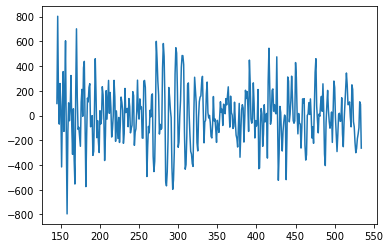

In [11]:
# Differencing at seasonal level


dif1s12 = sm.tsa.statespace.tools.diff(df.average, k_diff=1, k_seasonal_diff=12, seasonal_periods=12)

plt.plot(dif1s12)
plt.show()

It appears that the seasonal component has now been removed aswell, and now the series seems to resemble white noise.

However, we should still look at the correlation plots and perform a unit root test.


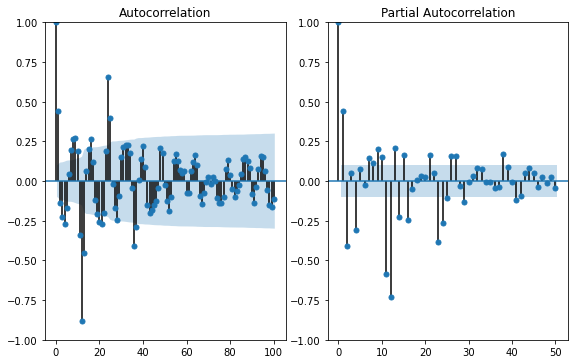

stat=-9.802, p=0.000
stationary at 0.05 significane level


In [12]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.tight_layout()
sm.graphics.tsa.plot_acf(dif1s12,lags=100, ax=ax[0])
sm.graphics.tsa.plot_pacf(dif1s12,lags=50, ax=ax[1])
plt.show()

# Augmented Dickey Fuller Test

adf_stat, p, _,_,_,_ = sm.tsa.stattools.adfuller(dif1s12)
print('stat=%.3f, p=%.3f' % (adf_stat, p))
if p > 0.05:
    print('Not Stationary at 0.05 significance level')
else:
    print('stationary at 0.05 significane level')




THE ADF test, which is a unit root test, is now telling us at the 0.05 significance level that the data is now stationary


At this point we could run a loop to go through candidate models and select the best one based on some criteria like AIC, or we can investigate the ACF and PACF plots


### Searching for an SARIMA model

Since the PACF and ACF plots are not definitive answers to what our Seasonal and Non Seasonal AR / MA terms should be, it would advisable to iteratively search over suitable paramters on.

As for the criterion, we can both use AIC and BIC to determine what model is best, and of course looking at the residuals.

#### Generic Grid Search

In [13]:
# Define the paramters to take on a number between 0 and 2
# From the ACF and PACF plots we shouldnt need seasonal or non seasonal terms
#  higher than this

p = d = q = range(0, 2)

# Generating all possible combinations
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]






In [14]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            model = sm.tsa.statespace.SARIMAX(df.average,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 0, 1)x(0, 1, 1, 12) model - AIC:-760.9983894539287


#### The grid search procedure for the best model has told us, based on the AIC criterion, that (1,0,1)x(0,1,1)[12] model yielded the lowest AIC of ~ -760




                                     SARIMAX Results                                      
Dep. Variable:                            average   No. Observations:                  535
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 384.499
Date:                            Sun, 28 Jan 2024   AIC                           -760.998
Time:                                    19:30:41   BIC                           -744.069
Sample:                                         0   HQIC                          -754.360
                                            - 535                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0009      0.001   1208.698      0.000       0.999       1.003
ma.L1          0.8039      0.025   

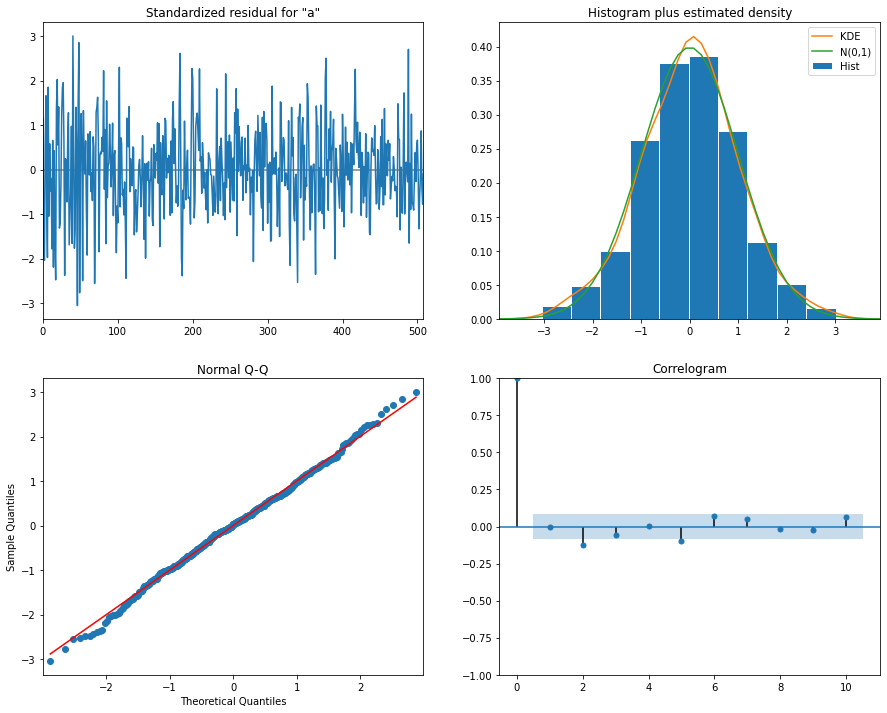

      lb_stat     lb_pvalue
1   39.241411  3.745122e-10
2   45.423226  1.369216e-10
3   46.289301  4.922456e-10
4   46.398408  2.034767e-09
5   46.412015  7.486551e-09
6   46.412373  2.450442e-08
7   46.424720  7.226403e-08
8   46.485826  1.921348e-07
9   47.019721  3.891602e-07
10  51.023455  1.729110e-07


In [15]:

mod1=sm.tsa.statespace.SARIMAX(df.average,order=(1,0,1),seasonal_order=(0,1,1,12),enforce_stationarity=False,
                                             enforce_invertibility=False)
results=mod1.fit()

print(results.summary().tables[0])
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15,12))
plt.show()



ljung = sm.stats.diagnostic.acorr_ljungbox(results.resid)
print(ljung)


#### The diagnostic plots are all indicating that this is a good model however, the Bof Ljung Statistic is showing P-Values all significantly less than 0.05

                                     SARIMAX Results                                      
Dep. Variable:                            average   No. Observations:                  535
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 383.380
Date:                            Sun, 28 Jan 2024   AIC                           -760.760
Time:                                    19:39:17   BIC                           -748.068
Sample:                                         0   HQIC                          -755.783
                                            - 535                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8031      0.025     31.577      0.000       0.753       0.853
ma.S.L12      -0.8633      0.028   

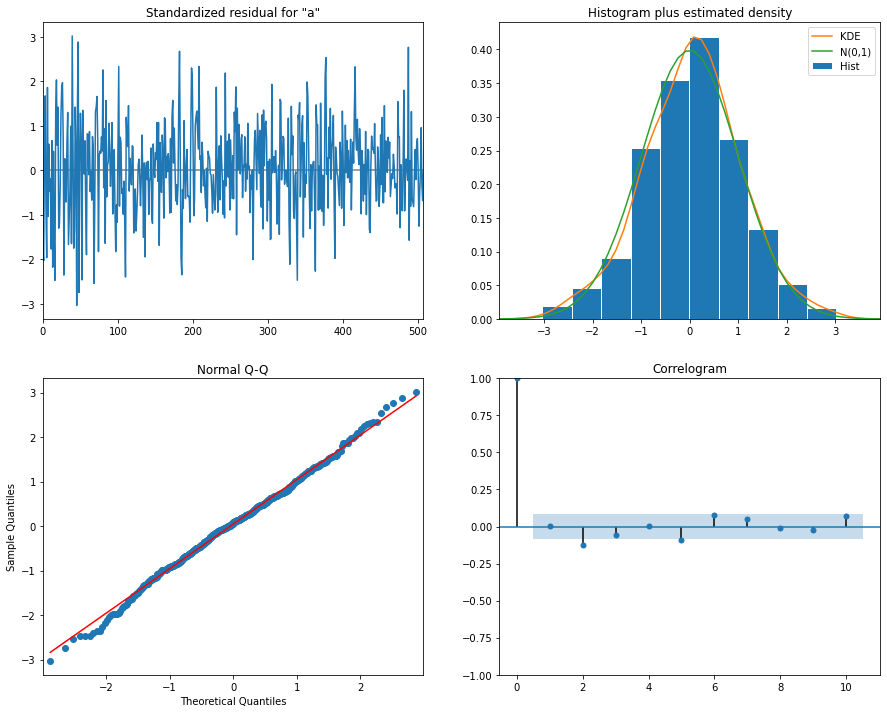

        lb_stat  lb_pvalue
1      0.000767   0.977902
2      0.000895   0.999553
3      0.001231   0.999989
4      0.002261   0.999999
5      0.002263   1.000000
..          ...        ...
96   116.446160   0.076429
97   116.446173   0.086981
98   116.446379   0.098542
99   116.446388   0.111148
100  116.446421   0.124819

[100 rows x 2 columns]


In [22]:
mod2=sm.tsa.statespace.SARIMAX(df.average,order=(0,1,1),seasonal_order=(0,1,1,12),enforce_stationarity=False,
                                             enforce_invertibility=False)
results=mod2.fit()

print(results.summary().tables[0])
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15,12))
plt.show()



ljung = sm.stats.diagnostic.acorr_ljungbox(results.resid,lags=100)
print(ljung)

#### This is a much better result. The Diagnostic plots are still what we are looking for, all terms are deemed significant, and all the Box Ljung p-values are > 0.05, meaning we cannot reject the null hypothesis that no auto-correlation between the series

We found that Generic Grid Search did find the lowest AIC model, but however it could not account for residual correlation. Rather, based on the results above on perfoming a 1st Order Difference and differencing at the seasonal level achieved better results regarding residual correlation, while also at the same AIC of -760.




